In [30]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
df_screentime_raw = pd.concat([pd.read_csv(f) for f in glob.glob("../data/screentime*.csv")]).drop_duplicates()
df_screentime_raw

,app,usage,start_time,end_time,created_at,tz,device_id,device_model
0,com.apple.finder,3,1752110682,1752110685,1.752111e+09,-18000,NaN,NaN
1,com.apple.Terminal,1,1752110681,1752110682,1.752111e+09,-18000,NaN,NaN
2,com.apple.finder,12,1752110669,1752110681,1.752111e+09,-18000,NaN,NaN
3,com.microsoft.VSCode,3,1752110666,1752110669,1.752111e+09,-18000,NaN,NaN
4,com.tableausoftware.tableaudesktop,86,1752110580,1752110666,1.752111e+09,-18000,NaN,NaN
...,...,...,...,...,...,...,...,...
3871,com.apple.MobileSMS,3,1720368014,1720368017,1.720368e+09,-18000,EB445137-D7F5-57EC-87DA-1DB460D64046,"iPhone13,2"
3872,com.apple.Health,85,1720366254,1720366339,1.720366e+09,-18000,EB445137-D7F5-57EC-87DA-1DB460D64046,"iPhone13,2"
3873,com.apple.findmy,10,1720366233,1720366243,1.720366e+09,-18000,EB445137-D7F5-57EC-87DA-1DB460D64046,"iPhone13,2"
3874,com.apple.mobiletimer,31,1720366200,1720366231,1.720366e+09,-18000,EB445137-D7F5-57EC-87DA-1DB460D64046,"iPhone13,2"


## Data Dictionary
Each row represents a screen time session.

- `app`: Name of the application used during the screen time session.
- `usage`: Duration of the screen time session in seconds.
- `start_time`: Timestamp of when the screen time session started.
- `end_time`: Timestamp of when the screen time session ended.
- `created_at`: Timestamp of when the record was created.
- `tz`: Timezone of the screen time session.
- `device_id`: Unique identifier for the device.
- `device_model`: Model of the device. Missing values imply the device was a macOS device.


In [32]:
df_screentime_raw.isna().sum()

app                 0
usage               0
start_time          0
end_time            0
created_at          0
tz                  0
device_id       68933
device_model    68933
dtype: int64

In [33]:
# sort by start_time
df_screentime_clean = df_screentime_raw.sort_values("start_time").reset_index(drop=True)

# convert timestamps to datetime
df_screentime_clean["start_time"] = df_screentime_clean["start_time"].apply(lambda x: datetime.fromtimestamp(x))
df_screentime_clean["end_time"] = df_screentime_clean["end_time"].apply(lambda x: datetime.fromtimestamp(x))
df_screentime_clean["created_at"] = df_screentime_clean["created_at"].apply(lambda x: datetime.fromtimestamp(x))

# create a new column for the date
df_screentime_clean["date"] = pd.to_datetime(df_screentime_clean["end_time"]).dt.date

# convert usage to hours
df_screentime_clean["usage"] = df_screentime_clean["usage"] / 3600

# fill missing device_model with 'macbook_pro'
df_screentime_clean['device_model'] = df_screentime_clean['device_model'].fillna('macbook_pro')

# select relevant columns and rename
df_screentime_clean = df_screentime_clean[['date', 'start_time', 'end_time', 'usage', 'device_model', 'app']].rename(columns={"device_model": "device"})

df_screentime_clean


,date,start_time,end_time,usage,device,app
0,2024-01-22,2024-01-22 10:23:59,2024-01-22 10:30:12,0.103611,macbook_pro,com.google.Chrome
1,2024-01-22,2024-01-22 10:30:12,2024-01-22 10:30:15,0.000833,macbook_pro,com.google.Chrome
2,2024-01-22,2024-01-22 10:53:10,2024-01-22 11:02:12,0.150556,macbook_pro,com.google.Chrome
3,2024-01-22,2024-01-22 11:02:12,2024-01-22 11:02:35,0.006389,macbook_pro,com.microsoft.Outlook
4,2024-01-22,2024-01-22 11:02:35,2024-01-22 11:35:52,0.554722,macbook_pro,com.google.Chrome
...,...,...,...,...,...,...
101208,2025-07-09,2025-07-09 20:23:00,2025-07-09 20:24:26,0.023889,macbook_pro,com.tableausoftware.tableaudesktop
101209,2025-07-09,2025-07-09 20:24:26,2025-07-09 20:24:29,0.000833,macbook_pro,com.microsoft.VSCode
101210,2025-07-09,2025-07-09 20:24:29,2025-07-09 20:24:41,0.003333,macbook_pro,com.apple.finder
101211,2025-07-09,2025-07-09 20:24:41,2025-07-09 20:24:42,0.000278,macbook_pro,com.apple.Terminal


In [34]:
df_screentime_agg = df_screentime_clean.groupby(['date', 'device', 'app']).agg({'usage': 'sum'}).reset_index()
df_screentime_agg.to_csv("../results/screentime_agg.csv", index=False)
df_screentime_agg

,date,device,app,usage
0,2024-01-22,macbook_pro,com.apple.iCal,0.003056
1,2024-01-22,macbook_pro,com.google.Chrome,2.668889
2,2024-01-22,macbook_pro,com.leomehlig.today,0.020000
3,2024-01-22,macbook_pro,com.microsoft.Outlook,0.006389
4,2024-01-22,macbook_pro,us.zoom.xos,0.078889
...,...,...,...,...
10552,2025-07-09,macbook_pro,com.leomehlig.today,0.136944
10553,2025-07-09,macbook_pro,com.microsoft.Outlook,0.090278
10554,2025-07-09,macbook_pro,com.microsoft.VSCode,0.925556
10555,2025-07-09,macbook_pro,com.tableausoftware.tableaudesktop,1.481944


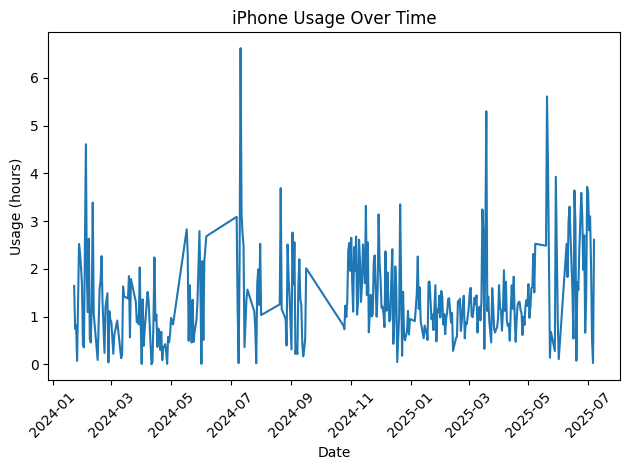

In [35]:
sns.lineplot(data=temp[temp['device'] == 'iPhone13,2'], x='date', y='usage')
plt.title('iPhone Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Usage (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

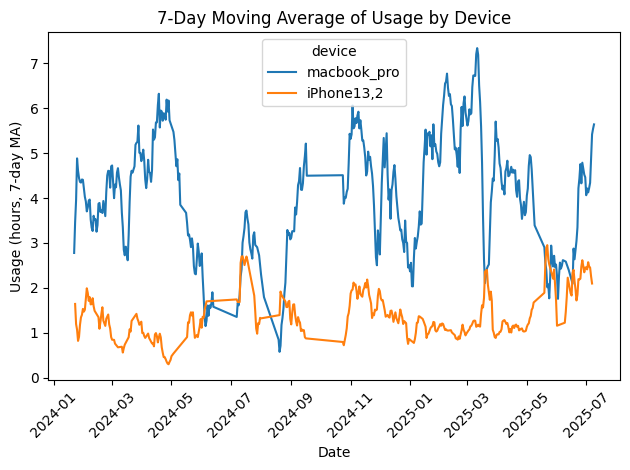

In [36]:
temp['usage_ma7'] = temp.groupby('device')['usage'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

sns.lineplot(data=temp, x='date', y='usage_ma7', hue='device')
plt.title('7-Day Moving Average of Usage by Device')
plt.xlabel('Date')
plt.ylabel('Usage (hours, 7-day MA)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
df_screentime_agg

,date,device,app,usage
0,2024-01-22,macbook_pro,com.apple.iCal,0.003056
1,2024-01-22,macbook_pro,com.google.Chrome,2.668889
2,2024-01-22,macbook_pro,com.leomehlig.today,0.020000
3,2024-01-22,macbook_pro,com.microsoft.Outlook,0.006389
4,2024-01-22,macbook_pro,us.zoom.xos,0.078889
...,...,...,...,...
10552,2025-07-09,macbook_pro,com.leomehlig.today,0.136944
10553,2025-07-09,macbook_pro,com.microsoft.Outlook,0.090278
10554,2025-07-09,macbook_pro,com.microsoft.VSCode,0.925556
10555,2025-07-09,macbook_pro,com.tableausoftware.tableaudesktop,1.481944


In [38]:
# Load app_categories.csv and merge with df_screentime_agg to group by category
app_categories = pd.read_csv("../data/app_categories.csv")  # assumes columns: app, category

df_screentime_agg = df_screentime_agg.merge(app_categories, on='app', how='left').fillna({'category': 'other'})

# # Now you can group by category
df_category_agg = df_screentime_agg.groupby(['date', 'device', 'category']).agg({'usage': 'sum'}).reset_index()
df_category_agg

,date,device,category,usage
0,2024-01-22,macbook_pro,browser,2.668889
1,2024-01-22,macbook_pro,productivity,0.108333
2,2024-01-23,"iPhone13,2",astro,0.009167
3,2024-01-23,"iPhone13,2",browser,0.180278
4,2024-01-23,"iPhone13,2",communication,0.099444
...,...,...,...,...
5550,2025-07-08,macbook_pro,utilities,0.010278
5551,2025-07-09,macbook_pro,browser,2.814444
5552,2025-07-09,macbook_pro,music,0.346111
5553,2025-07-09,macbook_pro,photo,0.001111


/var/folders/41/_gkgvhb94wd4156zplzr4cg00000gn/T/ipykernel_54151/2640428602.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=usage_by_category.values, y=usage_by_category.index, palette='viridis')


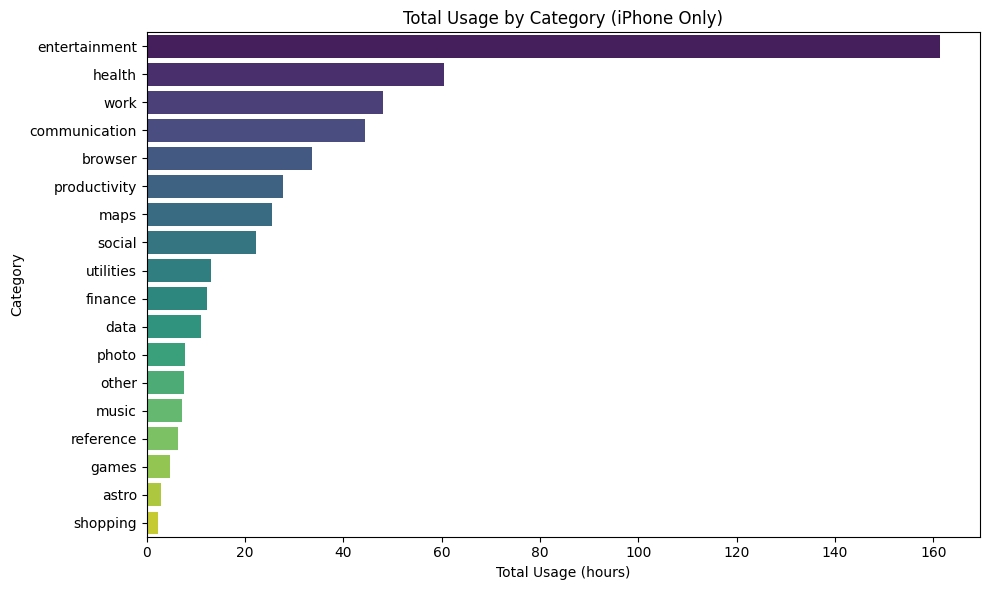

In [39]:
# Filter for iPhone device (assuming device name contains 'iPhone')
df_iphone = df_category_agg[df_category_agg['device'].str.contains('iPhone', case=False)]

# Aggregate total usage by category
usage_by_category = df_iphone.groupby('category')['usage'].sum().sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=usage_by_category.values, y=usage_by_category.index, palette='viridis')
plt.xlabel('Total Usage (hours)')
plt.ylabel('Category')
plt.title('Total Usage by Category (iPhone Only)')
plt.tight_layout()
plt.show()

In [40]:
# Filter for iPhone device and 'other' category
df_other = df_iphone[df_iphone['category'] == 'other']

# Aggregate total usage by app within 'other' category
usage_by_app_other = (
    df_screentime_agg[
        (df_screentime_agg['device'].str.contains('iPhone', case=False)) &
        (df_screentime_agg['category'] == 'other')
    ]
    .groupby('app')['usage']
    .sum()
    .sort_values(ascending=False)
)

# Show top 10 apps in 'other' category by usage
usage_by_app_other.head(10)

app
edu.illinois.rokwire.ios    1.970556
com.t11.celeste             0.895556
com.wbd.stream              0.826111
com.apple.AppStore          0.547222
com.zhiliaoapp.musically    0.339444
edu.cornell.birds.merlin    0.318889
com.apple.CoreAuthUI        0.310556
com.risesci.nyx             0.309167
com.alltrails.AllTrails     0.271111
com.markhambly.APOD         0.200833
Name: usage, dtype: float64